**LSTM Assignment** - 
Amit Wolf - 307854364
Idan Albilia - 311375612

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Flatten,Dense,LSTM,TimeDistributed,Input
from tensorflow.keras.models import Model

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Data Load**

In [6]:
ColumnNames = ["Timestamp","ActivityID","HeartRate","HandTemp","HandAcc1","HandAcc2","HandAcc3","Hand5","Hand6","Hand7","HandGyro1","HandGyro2","HandGyro3","HandMagno1","HandMagno2","HandMagno3","Hand14","Hand15","Hand16","Hand17","ChestTemp","ChestAcc1","ChestAcc2","ChestAcc3","Chest5","Chest6","Chest7","ChestGyro1","ChestGyro2","ChestGyro3","ChestMagno1","ChestMagno2","ChestMagno3","Chest14","Chest15","Chest16","Chest17","AnkleTemp","AnkleAcc1","AnkleAcc2","AnkleAcc3","Ankle5","Ankle6","Ankle7","AnkleGyro1","AnkleGyro2","AnkleGyro3","AnkleMagno1","AnkleMagno2","AnkleMagno3","Ankle14","Ankle15","Ankle16","Ankle17"]
Sub100 = pd.read_csv('/content/drive/MyDrive/Assignment2/Protocol/subject101.dat',delimiter = " ", names=ColumnNames)
Sub101 = pd.read_csv('/content/drive/MyDrive/Assignment2/Protocol/subject102.dat',delimiter = " ", names=ColumnNames)
Sub102 = pd.read_csv('/content/drive/MyDrive/Assignment2/Protocol/subject103.dat',delimiter = " ", names=ColumnNames)
Sub103 = pd.read_csv('/content/drive/MyDrive/Assignment2/Protocol/subject104.dat',delimiter = " ", names=ColumnNames)
Sub104 = pd.read_csv('/content/drive/MyDrive/Assignment2/Protocol/subject105.dat',delimiter = " ", names=ColumnNames)
Sub105 = pd.read_csv('/content/drive/MyDrive/Assignment2/Protocol/subject106.dat',delimiter = " ", names=ColumnNames)
Sub106 = pd.read_csv('/content/drive/MyDrive/Assignment2/Protocol/subject109.dat',delimiter = " ", names=ColumnNames)
Sub107 = pd.read_csv('/content/drive/MyDrive/Assignment2/Protocol/subject107.dat',delimiter = " ", names=ColumnNames)
Sub108 = pd.read_csv('/content/drive/MyDrive/Assignment2/Protocol/subject108.dat',delimiter = " ", names=ColumnNames)
AllSubjects = [Sub100,Sub101,Sub102,Sub103,Sub104,Sub105,Sub106,Sub107,Sub108]

# **Part 1**

## **Data Exploration**

From the data description we know that the frequency of heartrate neasurements is lower than the other measurements , so in order to solve this issue we need to add a interpolation function to fill the gaps of measurements.

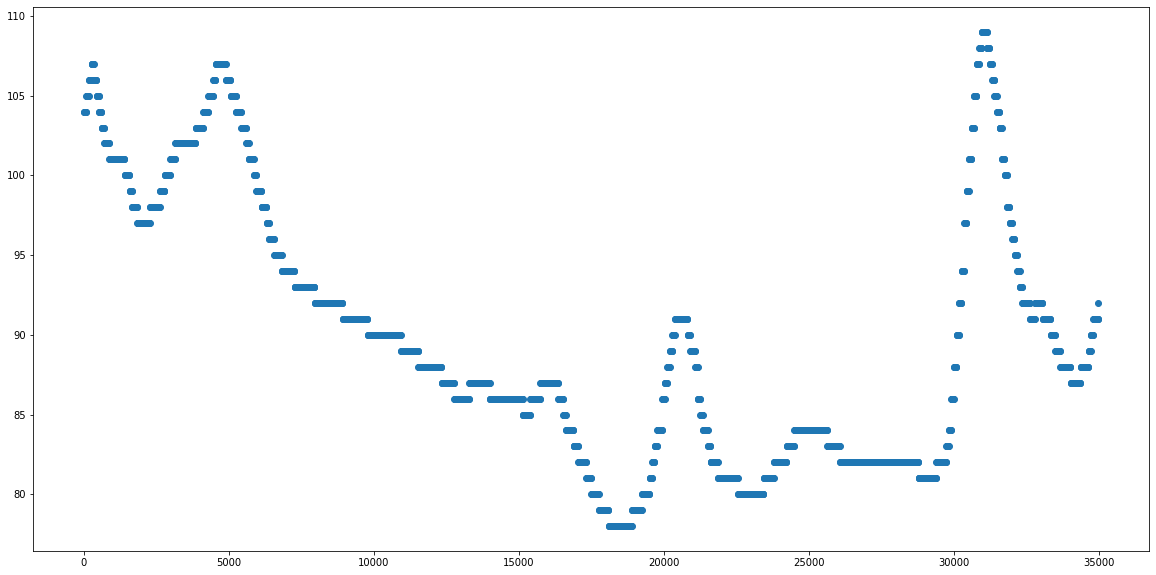

In [79]:
plt.figure(figsize = (20,10))
plt.scatter(x= range(0,35000), y=AllSubjects[0].HeartRate[0:35000])



In [80]:
UniqueActivities = [Sub.ActivityID.unique() for Sub in AllSubjects]
np.unique(np.concatenate(UniqueActivities).ravel()).tolist()

[0, 1, 2, 3, 4, 5, 6, 7, 12, 13, 16, 17, 24]

We can see that only 12 of the valid Activity id's are present in the data, meaning we would have to convert the id's to ids between the range of 0-11.

## **Data Preperation**

the following preperation has multiple purposes :


1. Dispose of columns marked as irrelevant in the data description.
2. Dispose of rows with the '0' ActivityID - stated to be irrelevant aswell.
3. Applies the Interpolation function on the Heartrate column.
4. Converts all activity id's to 0-11 range.



In [7]:
ConvertID = {1:0, 2:1, 3:2, 4:3, 5:4, 6:5,7:6, 12:7, 13:8, 16:9, 17:10, 24:11
}

def CleanColumns(df):
  return df.drop(columns=['Hand5','Hand6','Hand7',"Hand14","Hand15","Hand16","Hand17","Chest5","Chest6","Chest7","Chest14","Chest15","Chest16","Chest17","Ankle5","Ankle6","Ankle7","Ankle14","Ankle15","Ankle16","Ankle17"])

def CleanRows(df):
  return df.drop(df[df.ActivityID == 0].index)

def CleanDF(df):
  df = CleanColumns(df)
  df = CleanRows(df)
  return df  

def CleanDFs(dfs):
  for x in range(len(dfs)):
    dfs[x]["HeartRate"] = dfs[x]["HeartRate"].interpolate()
    dfs[x] = CleanDF(dfs[x])
    dfs[x]['ActivityID'] = dfs[x]['ActivityID'].apply(lambda x: ConvertID[x])
  return dfs

In [8]:
CleanDFs(AllSubjects)
AllSubjects

[        Timestamp  ActivityID  HeartRate  ...  AnkleMagno1  AnkleMagno2  AnkleMagno3
 2928        37.66           0      100.0  ...     -61.1081     -36.8636     -58.3696
 2929        37.67           0      100.0  ...     -60.8916     -36.3197     -58.3656
 2930        37.68           0      100.0  ...     -60.3407     -35.7842     -58.6119
 2931        37.69           0      100.0  ...     -60.7646     -37.1028     -57.8799
 2932        37.70           0      100.0  ...     -60.2040     -37.1225     -57.8847
 ...           ...         ...        ...  ...          ...          ...          ...
 361795    3626.33          11      183.0  ...     -56.3324     -29.6397      34.1311
 361796    3626.34          11      183.0  ...     -55.7786     -29.1093      34.2560
 361797    3626.35          11      183.0  ...     -55.5371     -29.5769      35.6106
 361798    3626.36          11      183.0  ...     -56.4328     -30.1943      34.6211
 361799    3626.37          11      183.0  ...     -56

## Per **Activity**

In the following section we will plot some graphs to try and analyze the data visually to see any interesting patterns. we will divide the analysis to 4 parts, each testing another activity:


1. Lying - the most rested activity
2. walking - increased movement, low effort (regarding Heartrate)
3. running - increased movement, higher effort (regarding Heartrate)
4. rope jumping - different movement pattern, even higher effort (regarding Heartrate)


In [84]:
def GetHandXAndY(df,Property,num):
  X = df['Timestamp'][:num]
  if(Property=="HeartRate"):
    df.dropna(inplace=True)
    Y = df['HeartRate'][:num]
    return X,Y
  else:
    Y1 = df[Property+'Temp'][:num]
    Y2 = df[Property+'Acc1'][:num]
    Y3 = df[Property+'Acc2'][:num]
    Y4 = df[Property+'Acc3'][:num]
    Y5 = df[Property+'Gyro1'][:num]
    Y6 = df[Property+'Gyro2'][:num]
    Y7 = df[Property+'Gyro3'][:num]
    Y8 = df[Property+'Magno1'][:num]
    Y9 = df[Property+'Magno2'][:num]
    Y10 = df[Property+'Magno3'][:num]
    return X,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10


### **Lying**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


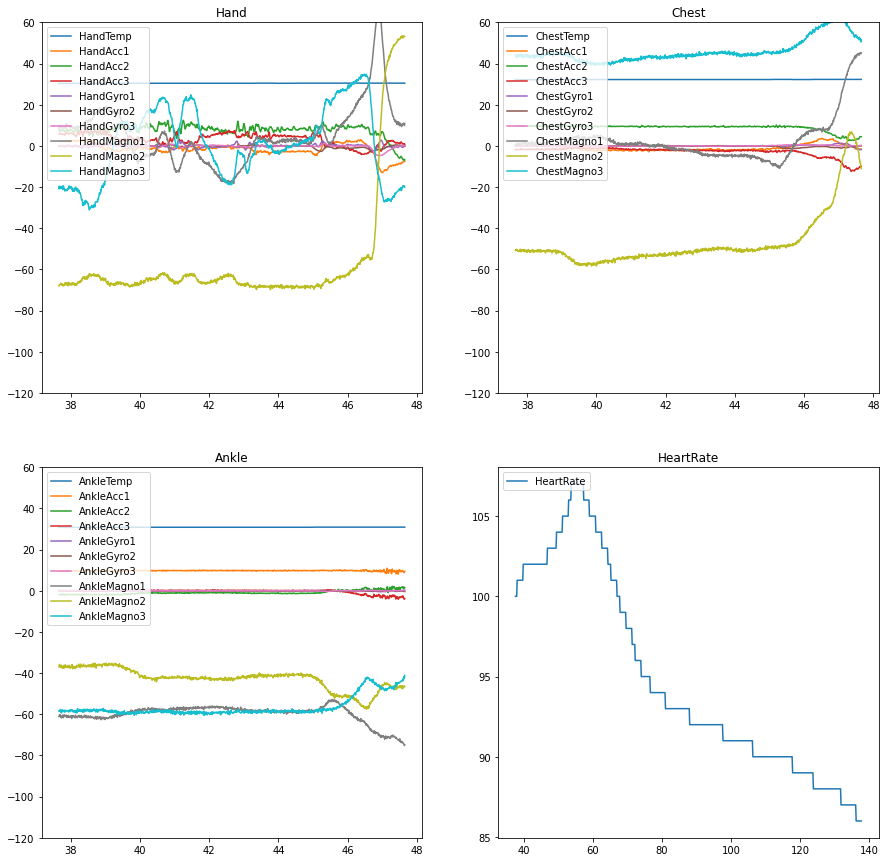

In [105]:
Sub100Lying = Sub100.loc[Sub100['ActivityID'] == 1]
fig, axs = plt.subplots(2, 2,figsize=(15,15))

X,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10 = GetHandXAndY(Sub100Lying,'Hand',1000)

axs[0, 0].set_title('Hand')
axs[0, 0].set_ylim([-120,60])
axs[0, 0].plot(X,Y1)
axs[0, 0].plot(X,Y2) 
axs[0, 0].plot(X,Y3) 
axs[0, 0].plot(X,Y4) 
axs[0, 0].plot(X,Y5)
axs[0, 0].plot(X,Y6)
axs[0, 0].plot(X,Y7)
axs[0, 0].plot(X,Y8)
axs[0, 0].plot(X,Y9)
axs[0, 0].plot(X,Y10)
axs[0, 0].legend(['HandTemp', 'HandAcc1', 'HandAcc2', 'HandAcc3', 'HandGyro1','HandGyro2','HandGyro3','HandMagno1','HandMagno2','HandMagno3'], loc='upper left')


X,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10 = GetHandXAndY(Sub100Lying,'Chest',1000)

axs[0, 1].set_title('Chest')
axs[0, 1].set_ylim([-120,60])
axs[0, 1].plot(X,Y1) 
axs[0, 1].plot(X,Y2) 
axs[0, 1].plot(X,Y3) 
axs[0, 1].plot(X,Y4) 
axs[0, 1].plot(X,Y5)
axs[0, 1].plot(X,Y6)
axs[0, 1].plot(X,Y7)
axs[0, 1].plot(X,Y8)
axs[0, 1].plot(X,Y9)
axs[0, 1].plot(X,Y10)
axs[0, 1].legend(['ChestTemp', 'ChestAcc1', 'ChestAcc2', 'ChestAcc3', 'ChestGyro1','ChestGyro2','ChestGyro3','ChestMagno1','ChestMagno2','ChestMagno3'], loc='upper left')


X,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10 = GetHandXAndY(Sub100Lying,'Ankle',1000)

axs[1, 0].set_title('Ankle')
axs[1, 0].set_ylim([-120,60])
axs[1, 0].plot(X,Y1) 
axs[1, 0].plot(X,Y2) 
axs[1, 0].plot(X,Y3) 
axs[1, 0].plot(X,Y4) 
axs[1, 0].plot(X,Y5)
axs[1, 0].plot(X,Y6)
axs[1, 0].plot(X,Y7)
axs[1, 0].plot(X,Y8)
axs[1, 0].plot(X,Y9)
axs[1, 0].plot(X,Y10)
axs[1, 0].legend(['AnkleTemp', 'AnkleAcc1', 'AnkleAcc2', 'AnkleAcc3', 'AnkleGyro1','AnkleGyro2','AnkleGyro3','AnkleMagno1','AnkleMagno2','AnkleMagno3'], loc='upper left')


X,Y = GetHandXAndY(Sub100Lying,'HeartRate',10000)

axs[1, 1].set_title('HeartRate')
axs[1, 1].plot(X,Y) 
axs[1, 1].legend(['HeartRate'], loc='upper left')


### **Walking**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


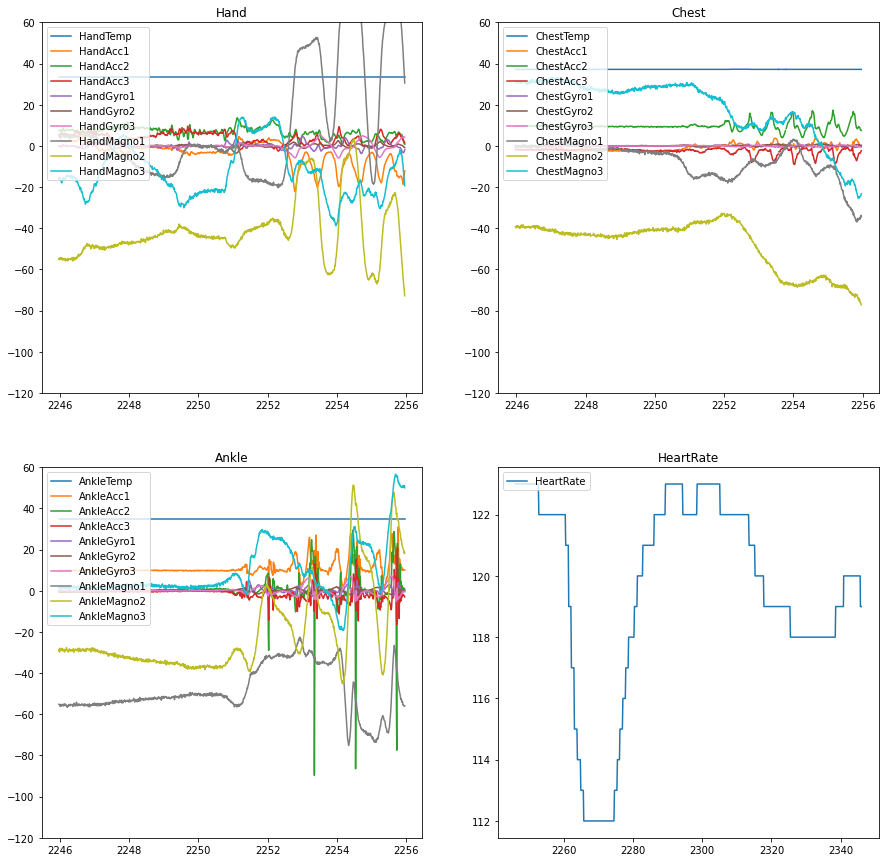

In [106]:
Sub100Walking = Sub100.loc[Sub100['ActivityID'] == 4]
fig, axs = plt.subplots(2, 2,figsize=(15,15))

X,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10 = GetHandXAndY(Sub100Walking,'Hand',1000)

axs[0, 0].set_title('Hand')
axs[0, 0].set_ylim([-120,60])
axs[0, 0].plot(X,Y1)
axs[0, 0].plot(X,Y2) 
axs[0, 0].plot(X,Y3) 
axs[0, 0].plot(X,Y4) 
axs[0, 0].plot(X,Y5)
axs[0, 0].plot(X,Y6)
axs[0, 0].plot(X,Y7)
axs[0, 0].plot(X,Y8)
axs[0, 0].plot(X,Y9)
axs[0, 0].plot(X,Y10)
axs[0, 0].legend(['HandTemp', 'HandAcc1', 'HandAcc2', 'HandAcc3', 'HandGyro1','HandGyro2','HandGyro3','HandMagno1','HandMagno2','HandMagno3'], loc='upper left')


X,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10 = GetHandXAndY(Sub100Walking,'Chest',1000)

axs[0, 1].set_title('Chest')
axs[0, 1].set_ylim([-120,60])
axs[0, 1].plot(X,Y1) 
axs[0, 1].plot(X,Y2) 
axs[0, 1].plot(X,Y3) 
axs[0, 1].plot(X,Y4) 
axs[0, 1].plot(X,Y5)
axs[0, 1].plot(X,Y6)
axs[0, 1].plot(X,Y7)
axs[0, 1].plot(X,Y8)
axs[0, 1].plot(X,Y9)
axs[0, 1].plot(X,Y10)
axs[0, 1].legend(['ChestTemp', 'ChestAcc1', 'ChestAcc2', 'ChestAcc3', 'ChestGyro1','ChestGyro2','ChestGyro3','ChestMagno1','ChestMagno2','ChestMagno3'], loc='upper left')


X,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10 = GetHandXAndY(Sub100Walking,'Ankle',1000)

axs[1, 0].set_title('Ankle')
axs[1, 0].set_ylim([-120,60])
axs[1, 0].plot(X,Y1) 
axs[1, 0].plot(X,Y2) 
axs[1, 0].plot(X,Y3) 
axs[1, 0].plot(X,Y4) 
axs[1, 0].plot(X,Y5)
axs[1, 0].plot(X,Y6)
axs[1, 0].plot(X,Y7)
axs[1, 0].plot(X,Y8)
axs[1, 0].plot(X,Y9)
axs[1, 0].plot(X,Y10)
axs[1, 0].legend(['AnkleTemp', 'AnkleAcc1', 'AnkleAcc2', 'AnkleAcc3', 'AnkleGyro1','AnkleGyro2','AnkleGyro3','AnkleMagno1','AnkleMagno2','AnkleMagno3'], loc='upper left')


X,Y = GetHandXAndY(Sub100Walking,'HeartRate',10000)

axs[1, 1].set_title('HeartRate')
axs[1, 1].plot(X,Y) 
axs[1, 1].legend(['HeartRate'], loc='upper left')


### **Running**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


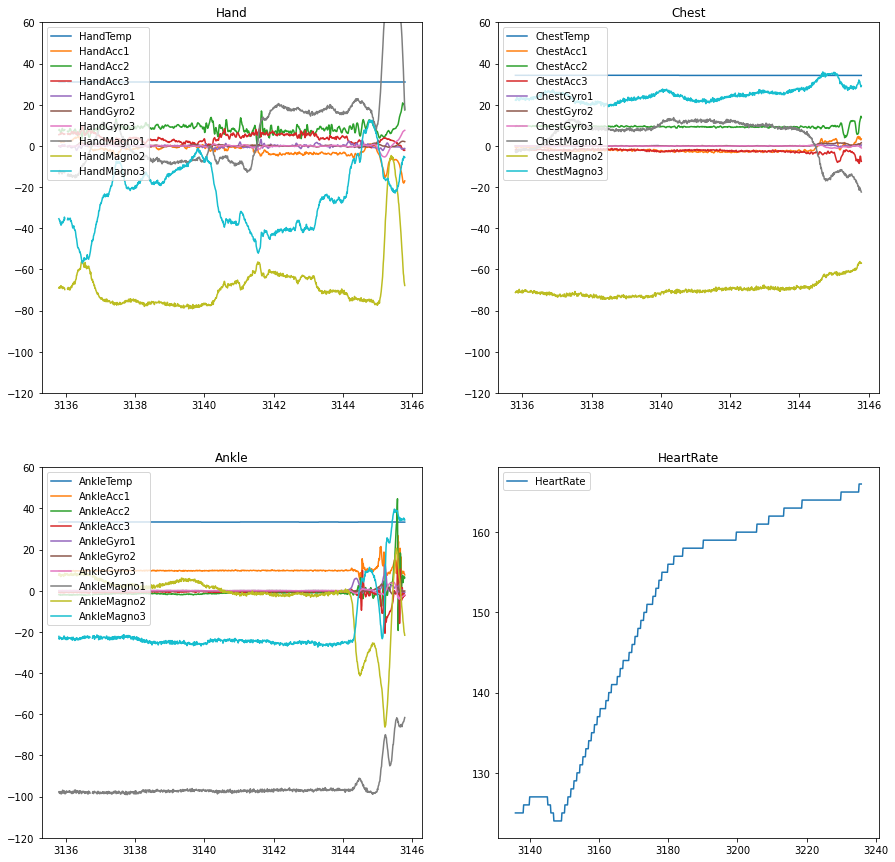

In [110]:
Sub100Running = Sub100.loc[Sub100['ActivityID'] == 5]
fig, axs = plt.subplots(2, 2,figsize=(15,15))

X,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10 = GetHandXAndY(Sub100Running,'Hand',1000)

axs[0, 0].set_title('Hand')
axs[0, 0].set_ylim([-120,60])
axs[0, 0].plot(X,Y1)
axs[0, 0].plot(X,Y2) 
axs[0, 0].plot(X,Y3) 
axs[0, 0].plot(X,Y4) 
axs[0, 0].plot(X,Y5)
axs[0, 0].plot(X,Y6)
axs[0, 0].plot(X,Y7)
axs[0, 0].plot(X,Y8)
axs[0, 0].plot(X,Y9)
axs[0, 0].plot(X,Y10)
axs[0, 0].legend(['HandTemp', 'HandAcc1', 'HandAcc2', 'HandAcc3', 'HandGyro1','HandGyro2','HandGyro3','HandMagno1','HandMagno2','HandMagno3'], loc='upper left')


X,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10 = GetHandXAndY(Sub100Running,'Chest',1000)

axs[0, 1].set_title('Chest')
axs[0, 1].set_ylim([-120,60])
axs[0, 1].plot(X,Y1) 
axs[0, 1].plot(X,Y2) 
axs[0, 1].plot(X,Y3) 
axs[0, 1].plot(X,Y4) 
axs[0, 1].plot(X,Y5)
axs[0, 1].plot(X,Y6)
axs[0, 1].plot(X,Y7)
axs[0, 1].plot(X,Y8)
axs[0, 1].plot(X,Y9)
axs[0, 1].plot(X,Y10)
axs[0, 1].legend(['ChestTemp', 'ChestAcc1', 'ChestAcc2', 'ChestAcc3', 'ChestGyro1','ChestGyro2','ChestGyro3','ChestMagno1','ChestMagno2','ChestMagno3'], loc='upper left')


X,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10 = GetHandXAndY(Sub100Running,'Ankle',1000)

axs[1, 0].set_title('Ankle')
axs[1, 0].set_ylim([-120,60])
axs[1, 0].plot(X,Y1) 
axs[1, 0].plot(X,Y2) 
axs[1, 0].plot(X,Y3) 
axs[1, 0].plot(X,Y4) 
axs[1, 0].plot(X,Y5)
axs[1, 0].plot(X,Y6)
axs[1, 0].plot(X,Y7)
axs[1, 0].plot(X,Y8)
axs[1, 0].plot(X,Y9)
axs[1, 0].plot(X,Y10)
axs[1, 0].legend(['AnkleTemp', 'AnkleAcc1', 'AnkleAcc2', 'AnkleAcc3', 'AnkleGyro1','AnkleGyro2','AnkleGyro3','AnkleMagno1','AnkleMagno2','AnkleMagno3'], loc='upper left')


X,Y = GetHandXAndY(Sub100Running,'HeartRate',10000)

axs[1, 1].set_title('HeartRate')
axs[1, 1].plot(X,Y) 
axs[1, 1].legend(['HeartRate'], loc='upper left')


### **Rope Jumping**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


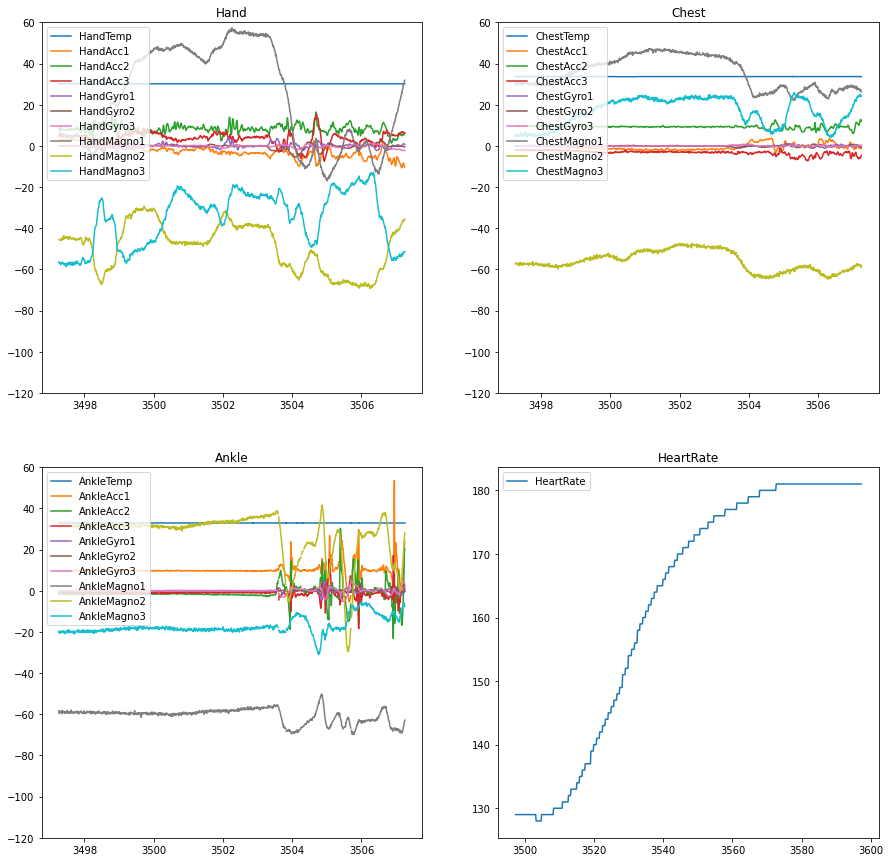

In [109]:
Sub100Rope = Sub100.loc[Sub100['ActivityID'] == 24]
fig, axs = plt.subplots(2, 2,figsize=(15,15))

X,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10 = GetHandXAndY(Sub100Rope,'Hand',1000)

axs[0, 0].set_title('Hand')
axs[0, 0].set_ylim([-120,60])
axs[0, 0].plot(X,Y1)
axs[0, 0].plot(X,Y2) 
axs[0, 0].plot(X,Y3) 
axs[0, 0].plot(X,Y4) 
axs[0, 0].plot(X,Y5)
axs[0, 0].plot(X,Y6)
axs[0, 0].plot(X,Y7)
axs[0, 0].plot(X,Y8)
axs[0, 0].plot(X,Y9)
axs[0, 0].plot(X,Y10)
axs[0, 0].legend(['HandTemp', 'HandAcc1', 'HandAcc2', 'HandAcc3', 'HandGyro1','HandGyro2','HandGyro3','HandMagno1','HandMagno2','HandMagno3'], loc='upper left')


X,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10 = GetHandXAndY(Sub100Rope,'Chest',1000)

axs[0, 1].set_title('Chest')
axs[0, 1].set_ylim([-120,60])
axs[0, 1].plot(X,Y1) 
axs[0, 1].plot(X,Y2) 
axs[0, 1].plot(X,Y3) 
axs[0, 1].plot(X,Y4) 
axs[0, 1].plot(X,Y5)
axs[0, 1].plot(X,Y6)
axs[0, 1].plot(X,Y7)
axs[0, 1].plot(X,Y8)
axs[0, 1].plot(X,Y9)
axs[0, 1].plot(X,Y10)
axs[0, 1].legend(['ChestTemp', 'ChestAcc1', 'ChestAcc2', 'ChestAcc3', 'ChestGyro1','ChestGyro2','ChestGyro3','ChestMagno1','ChestMagno2','ChestMagno3'], loc='upper left')


X,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10 = GetHandXAndY(Sub100Rope,'Ankle',1000)

axs[1, 0].set_title('Ankle')
axs[1, 0].set_ylim([-120,60])
axs[1, 0].plot(X,Y1) 
axs[1, 0].plot(X,Y2) 
axs[1, 0].plot(X,Y3) 
axs[1, 0].plot(X,Y4) 
axs[1, 0].plot(X,Y5)
axs[1, 0].plot(X,Y6)
axs[1, 0].plot(X,Y7)
axs[1, 0].plot(X,Y8)
axs[1, 0].plot(X,Y9)
axs[1, 0].plot(X,Y10)
axs[1, 0].legend(['AnkleTemp', 'AnkleAcc1', 'AnkleAcc2', 'AnkleAcc3', 'AnkleGyro1','AnkleGyro2','AnkleGyro3','AnkleMagno1','AnkleMagno2','AnkleMagno3'], loc='upper left')


X,Y = GetHandXAndY(Sub100Rope,'HeartRate',10000)

axs[1, 1].set_title('HeartRate')
axs[1, 1].plot(X,Y) 
axs[1, 1].legend(['HeartRate'], loc='upper left')


We can see that chest values seem to be rather similar between all activities, Heart rate seems like a strong way to identify activity. in the next section we will try and analyze correlation of features.

## **Per Feature**

Hands + Heartrate

            ActivityID  HeartRate  HandAcc1  HandGyro1  HandMagno1  HandTemp
ActivityID    1.000000   0.240101 -0.262128   0.051407    0.199301  0.125237
HeartRate     0.240101   1.000000 -0.253452   0.052884    0.276920 -0.241131
HandAcc1     -0.262128  -0.253452  1.000000   0.001358   -0.543638 -0.214616
HandGyro1     0.051407   0.052884  0.001358   1.000000    0.069379 -0.055801
HandMagno1    0.199301   0.276920 -0.543638   0.069379    1.000000  0.058752
HandTemp      0.125237  -0.241131 -0.214616  -0.055801    0.058752  1.000000


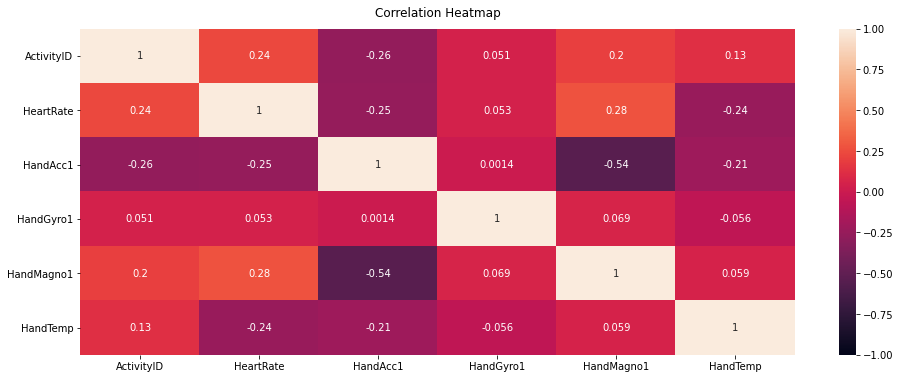

In [115]:
temperture_corr = Sub100[["ActivityID", "HeartRate", "HandAcc1", "HandGyro1", "HandMagno1", "HandTemp"]].corr()
print(temperture_corr)
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(temperture_corr, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);


Ankle

             ActivityID  AnkleAcc1  AnkleGyro1  AnkleMagno1  AnkleTemp
ActivityID     1.000000   0.079373   -0.008844     0.121219   0.206762
AnkleAcc1      0.079373   1.000000   -0.041242    -0.220041   0.313955
AnkleGyro1    -0.008844  -0.041242    1.000000    -0.017325  -0.008096
AnkleMagno1    0.121219  -0.220041   -0.017325     1.000000   0.015516
AnkleTemp      0.206762   0.313955   -0.008096     0.015516   1.000000


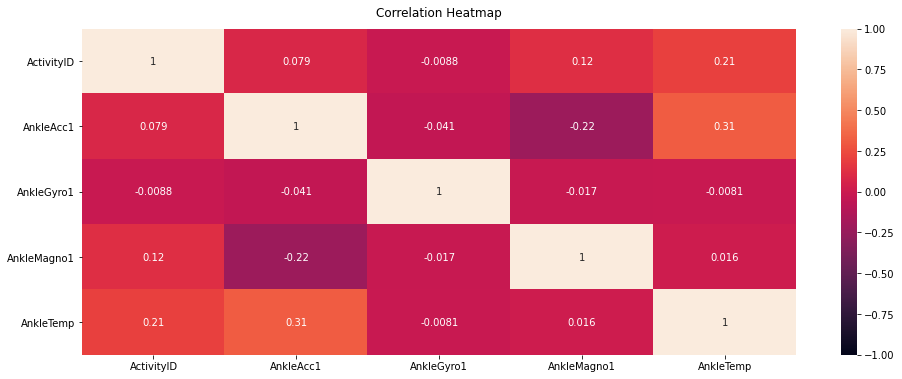

In [116]:
temperture_corr = Sub100[["ActivityID", "AnkleAcc1", "AnkleGyro1", "AnkleMagno1", "AnkleTemp"]].corr()
print(temperture_corr)
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(temperture_corr, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);


Chest

             ActivityID  ChestAcc1  ChestGyro1  ChestMagno1  ChestTemp
ActivityID     1.000000  -0.177557   -0.000583    -0.180490   0.063095
ChestAcc1     -0.177557   1.000000   -0.024114    -0.199966  -0.170847
ChestGyro1    -0.000583  -0.024114    1.000000    -0.000494  -0.007974
ChestMagno1   -0.180490  -0.199966   -0.000494     1.000000  -0.069102
ChestTemp      0.063095  -0.170847   -0.007974    -0.069102   1.000000


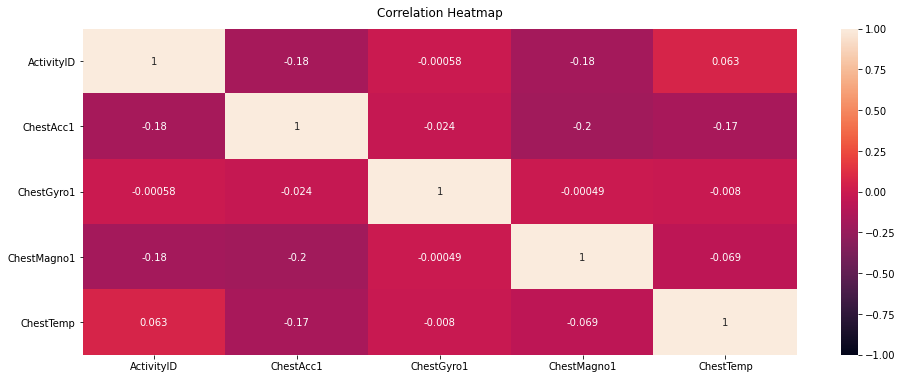

In [117]:
temperture_corr = Sub100[["ActivityID","ChestAcc1", "ChestGyro1", "ChestMagno1", "ChestTemp"]].corr()
print(temperture_corr)
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(temperture_corr, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);


We will choose a threshold of 0.1 or -0.1 to include in features, meaning the possible features to use are:
HeartRate, HandAcc1, HandMagno1, HandTemp, AnkleMagno1, AnkleTemp, ChestAcc1, ChestMagno1

## **Regression or Classification**


The main focus of this dataset - to predict an activity based on body parameters is a classification process.

The self-supervised task of predicting one of the other parameters is a regression problem.


## **1.c**

For a self-supervised task it seems that Heartrate is the best one because of the fact that it is more predictable than other features, and most importantly it has the highest correlation with all of the activities.

A second possible feature would be HandMagno1 which was also found to correlate well with the activity.

# **Part 2**

## **Classification Functions**

Get a single feature from a certain subject, number of lags is also given as a parameter.

In [9]:
def create_train_data(x,Feature,look_back,pred_steps,horizon):
    TargetsDF = pd.DataFrame(columns = ['ActivityID'])
    FeaturesDF =  pd.DataFrame(columns = [Feature,'ActivityID'])
    df = pd.DataFrame(data=x,columns=[Feature,'ActivityID'])
    Frames = []
    for IDNum in range(0,12):
      ActivityDF = x.loc[x['ActivityID'] == IDNum]
      for i in range(look_back):
          df['lag{}'.format(i)] = ActivityDF[Feature].shift(i+1)
      df['target'] = IDNum
      df.dropna(inplace=True)
      Frames.append(pd.DataFrame(data=df))
      df = pd.DataFrame(data=x,columns=[Feature,'ActivityID'])
    result = pd.concat(Frames)
    CleanFeatures = result.drop([Feature,'ActivityID','target'],axis=1)
    CleanTarget = result['target']  
    return CleanFeatures, CleanTarget

get multiple features for a specific subject, number of lags is also given as a parameter.

In [10]:
def create_train_data_Multi(x,Features,look_back,pred_steps,horizon):
    TargetsDF = pd.DataFrame(columns = ['ActivityID'])
    Features.append('ActivityID')
    FeaturesDF =  pd.DataFrame(columns = Features)
    df = pd.DataFrame(data=x,columns=Features)
    Frames = []
    for IDNum in range(0,12):
      ActivityDF = x.loc[x['ActivityID'] == IDNum]
      for index in range(0,len(Features)-1):
        for i in range(look_back):
            df['Feature'+str(index)+'lag{}'.format(i)] = ActivityDF[Features[index]].shift(i+1)
      # df['target'] = IDNum
      df.dropna(inplace=True)
      Frames.append(pd.DataFrame(data=df))
      df = pd.DataFrame(data=x,columns=Features)
    result = pd.concat(Frames)
    MultiFeatures = result.drop(Features,axis=1)
    MultiLabels = result['ActivityID']
    return MultiFeatures,MultiLabels

Get the wanted features from train subjects, number of lags is also given as a parameter.

In [11]:
def GetAllFeables(FeatureArray,lag):
  AllFeatures,AllTargets = create_train_data_Multi(AllSubjects[0],FeatureArray,lag,10,10)
  FeatureArray = FeatureArray[:-1]
  for x in range(5):
    if x==0:
      NewFeatures,NewTargets = create_train_data_Multi(AllSubjects[x+1],FeatureArray,lag,10,10)
      FeatureArray = FeatureArray[:-1]
    elif x==1:
      NewFeatures,NewTargets = create_train_data_Multi(AllSubjects[x+1],FeatureArray,lag,10,10)
      FeatureArray = FeatureArray[:-1]
    elif x==2:
      NewFeatures,NewTargets = create_train_data_Multi(AllSubjects[x+1],FeatureArray,lag,10,10)
      FeatureArray = FeatureArray[:-1]
    elif x==3:
      NewFeatures,NewTargets = create_train_data_Multi(AllSubjects[x+1],FeatureArray,lag,10,10)
      FeatureArray = FeatureArray[:-1]
    elif x==4:
      NewFeatures,NewTargets = create_train_data_Multi(AllSubjects[x+1],FeatureArray,lag,10,10)
      FeatureArray = FeatureArray[:-1]
    AllFeatures = pd.concat([AllFeatures,NewFeatures])
    AllTargets = pd.concat([AllTargets,NewTargets])
  a = AllTargets.values
  OneHotLabels = np.zeros((a.size, a.max()+1))
  OneHotLabels[np.arange(a.size),a] = 1
  return AllFeatures,OneHotLabels

Get the wanted features from subjects 7 and 8, number of lags is also given as a parameter.

In [31]:
def GetTestFeables(FeatureArray,lag):
  TestFeatures,TestTargets = create_train_data_Multi(AllSubjects[7],FeatureArray,lag,10,10)
  NewFeatures,NewTargets = create_train_data_Multi(AllSubjects[8],FeatureArray[:-1],lag,10,10)
  TestFeatures = pd.concat([TestFeatures,NewFeatures])
  TestTargets = pd.concat([TestTargets,NewTargets])
  a = TestTargets.values
  OneHotTestLabels = np.zeros((a.size, a.max()+1))
  OneHotTestLabels[np.arange(a.size),a] = 1
  OneHotTestLabels.shape
  return TestFeatures,OneHotTestLabels

Get HotLabels

In [13]:
def GetHotLabels(Labels):
  a = Labels.values
  OneHotLabels = np.zeros((a.size, a.max()+1))
  OneHotLabels[np.arange(a.size),a] = 1
  return OneHotLabels

Decoder - [0 0 1] -> [2]

In [14]:
import tensorflow as tf
def decoder(predictions):
  toReturn = []
  print(len(predictions))
  for i in range(len(predictions)):
    for cell in range(len(predictions[i])):
      if predictions[i][cell]==1:
        toReturn.append(cell)
        bla=True
    if bla==False:
        toReturn.append(-1)
    bla=False
  print(len(toReturn))
  return toReturn


In [15]:
def createSelfSuper(x,Feature,look_back):
    TargetsDF = pd.DataFrame(columns = ['ActivityID'])
    FeaturesDF =  pd.DataFrame(columns = [Feature,'ActivityID'])
    df = pd.DataFrame(data=x,columns=[Feature,'ActivityID'])
    Frames = []
    for IDNum in range(0,12):
      ActivityDF = x.loc[x['ActivityID'] == IDNum]
      for i in range(look_back):
          df['lag{}'.format(i)] = ActivityDF[Feature].shift(i+1)
      df['target'] = IDNum
      df.dropna(inplace=True)
      Frames.append(pd.DataFrame(data=df))
      df = pd.DataFrame(data=x,columns=[Feature,'ActivityID'])
    result = pd.concat(Frames)
    CleanFeatures = result.drop([Feature,'ActivityID','target','lag90','lag91','lag92','lag93','lag94','lag95','lag96','lag97','lag98','lag99'],axis=1)
    CleanTarget = result['lag99']  
    return CleanFeatures, CleanTarget

## **Naive Baseline**

We will use Heartrate as a naive baseline to determine the activity.
first we will measure the average Heartrate for each activity, and then we will build a function that predicts an activity based on the heartrate of each row.

The algorithm will be simple -  if the HR is between two averages it will be categorized as the lower average of the two.

In [64]:
def GetHeartRateAvg(df):
  HeartRate = []
  for IDNum in range(0,12):
    ActivityDF = df.loc[df['ActivityID'] == IDNum]
    HeartRate.append(ActivityDF["HeartRate"].mean())
  return HeartRate

HRAverages = GetHeartRateAvg(AllSubjects[0])
for i in range(len(HRAverages)):
  print(i)
  print(HRAverages[i])

0
87.52766027880972
1
91.18381601362861
2
103.42568034258875
3
120.44074956185683
4
161.3614389842464
5
127.21760339342524
6
139.64480631630892
7
144.29521711768407
8
138.62849855695012
9
130.24425700710518
10
99.51650193017436
11
165.98904120198264


In [67]:
testFeatures = ['HeartRate']
TestFeaturesNaive, TestLabelsNaive = GetTestFeables(testFeatures,1)
print(TestFeaturesNaive)
print(TestLabelsNaive)

        Feature0lag0
2929           100.0
2930           100.0
2931           100.0
2932           100.0
2933           100.0
...              ...
361812         131.0
361813         131.0
361814         131.0
361815         131.0
361816         131.0

[1441536 rows x 1 columns]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
        Feature0lag0
7837            80.0
7838            80.0
7839            80.0
7840            80.0
7841            80.0
...              ...
388248         201.0
388249         201.0
388250         201.0
388251         201.0
388252         201.0

[494855 rows x 1 columns]
[ 0  0  0 ... 11 11 11]


In [71]:
import tensorflow as tf
def NaivePredict(HeartRates):
  toReturn = []
  HRArray = np.array(HeartRates)
  print(len(HRArray))
  for i in range(len(HRArray)):
    if HRArray[i]>=165:
      toReturn.append(11)
    elif HRArray[i]>=161:
      toReturn.append(4)
    elif HRArray[i]>=144:
      toReturn.append(7)
    elif HRArray[i]>=139:
      toReturn.append(6)
    elif HRArray[i]>=138:
      toReturn.append(8)
    elif HRArray[i]>=130:
      toReturn.append(9)
    elif HRArray[i]>=127:
      toReturn.append(5)
    elif HRArray[i]>=120:
      toReturn.append(3)
    elif HRArray[i]>=103:
      toReturn.append(2)
    elif HRArray[i]>=103:
      toReturn.append(10)
    elif HRArray[i]>=91:
      toReturn.append(1)
    else:
      toReturn.append(0)
  print(len(toReturn))
  return toReturn

predicted= NaivePredict(TestFeaturesNaive)
print(predicted)

494855
494855
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [73]:
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss
print(accuracy_score(TestLabelsNaive, predicted))

0.19043962372816278


This result (19%) is obviously low on one hand, but considering the method used to predict its more than we expected. Still, we can improve greatly on this result. 

## **Classical ML Algorithm**

In [24]:
testFeatures = ['HandMagno1','AnkleMagno1','HeartRate']
AllFeaturesClassic,AllLabelsClassic = GetAllFeables(testFeatures,1)
print(AllFeaturesClassic)
print(AllLabelsClassic)
testFeatures = ['HandMagno1','AnkleMagno1','HeartRate']
TestFeaturesCL, TestLabelsCL = GetTestFeables(testFeatures,1)
print(testdecoder.shape)
print(TestLabelsCL.shape)


        Feature0lag0  Feature1lag0  Feature2lag0
2929         8.93200      -61.1081         100.0
2930         9.58300      -60.8916         100.0
2931         9.05516      -60.3407         100.0
2932         9.92698      -60.7646         100.0
2933         9.15626      -60.2040         100.0
...              ...           ...           ...
361812      17.90400      -38.1717         131.0
361813      17.90680      -38.1725         131.0
361814      17.89960      -38.0362         131.0
361815      18.14770      -38.0342         131.0
361816      17.77750      -38.5510         131.0

[1416565 rows x 3 columns]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
        Feature0lag0  Feature1lag0  Feature2lag0
7837        48.13270      -54.0963          80.0
7838        47.39610      -53.8479          80.0
7839        48.15010      -53.5679          80.0
7840        47.75680      -53.83

In [27]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3)
model.fit(AllFeaturesClassic,AllLabelsClassic)

predicted= model.predict(TestFeaturesCL) 
print(predicted)
print(TestLabelsCL)


[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
[ 0  0  0 ... 11 11 11]


In [50]:
testdecoder = decoder(predicted)
print(testdecoder)

487291
487291
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [51]:
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss
print(accuracy_score(TestLabelsCL, testdecoder))

0.39558292683427354


The Classical ML Algorithm has finished with the result of almost 40% which is quite impressive. Now we will try and improve on this score with more complicated models.

# Train Data - Subject #1 |
# Validation Data - Subject #1

We will start out with a very simple LSTM model and one feature on just one subject.


In [134]:
from sklearn.model_selection import train_test_split

CleanFeatures, CleanTarget  = create_train_data(AllSubjects[0],'HandMagno1',100,10,10)
print(CleanFeatures, CleanTarget)

OneHotLabels = GetHotLabels(CleanTarget)

X_train, X_test, y_train, y_test = train_test_split(CleanFeatures, OneHotLabels, test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

           lag0     lag1     lag2  ...     lag97     lag98     lag99
3028    14.0033  13.2316  13.1259  ...   9.05516   9.58300   8.93200
3029    14.7918  14.0033  13.2316  ...   9.92698   9.05516   9.58300
3030    14.3656  14.7918  14.0033  ...   9.15626   9.92698   9.05516
3031    15.9068  14.3656  14.7918  ...   8.60505   9.15626   9.92698
3032    14.9204  15.9068  14.3656  ...   9.16003   8.60505   9.15626
...         ...      ...      ...  ...       ...       ...       ...
361795 -45.9493 -46.1446 -46.0392  ... -47.34660 -46.78980 -46.45480
361796 -46.6021 -45.9493 -46.1446  ... -46.80710 -47.34660 -46.78980
361797 -45.8302 -46.6021 -45.9493  ... -47.14720 -46.80710 -47.34660
361798 -47.1775 -45.8302 -46.6021  ... -47.48950 -47.14720 -46.80710
361799 -46.8446 -47.1775 -45.8302  ... -47.72630 -47.48950 -47.14720

[205517 rows x 100 columns] 3028       0
3029       0
3030       0
3031       0
3032       0
          ..
361795    11
361796    11
361797    11
361798    11
361799    11


In [133]:
inp = Input(shape=(100,1))
x = LSTM(10)(inp)
x = Dense(12,activation="softmax")(x)
model = Model(inp,x)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics = ['acc'])
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 100, 1)]          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 12)                132       
Total params: 612
Trainable params: 612
Non-trainable params: 0
_________________________________________________________________


## 10 lags, 10 weights

Epoch 1/10
6777/6777 [==============================] - 26s 4ms/step - loss: 2.1910 - acc: 0.2527 - val_loss: 2.0046 - val_acc: 0.3501
Epoch 2/10
6777/6777 [==============================] - 24s 4ms/step - loss: 1.9820 - acc: 0.3473 - val_loss: 1.9485 - val_acc: 0.3582
Epoch 3/10
6777/6777 [==============================] - 25s 4ms/step - loss: 1.9298 - acc: 0.3580 - val_loss: 1.9165 - val_acc: 0.3598
Epoch 4/10
6777/6777 [==============================] - 24s 4ms/step - loss: 1.9072 - acc: 0.3616 - val_loss: 1.8965 - val_acc: 0.3691
Epoch 5/10
6777/6777 [==============================] - 24s 4ms/step - loss: 1.8859 - acc: 0.3757 - val_loss: 1.8807 - val_acc: 0.3837
Epoch 6/10
6777/6777 [==============================] - 24s 4ms/step - loss: 1.8715 - acc: 0.3838 - val_loss: 1.8559 - val_acc: 0.3938
Epoch 7/10
6777/6777 [==============================] - 24s 4ms/step - loss: 1.8586 - acc: 0.3867 - val_loss: 1.8657 - val_acc: 0.3940
Epoch 8/10
6777/6777 [==============================] -

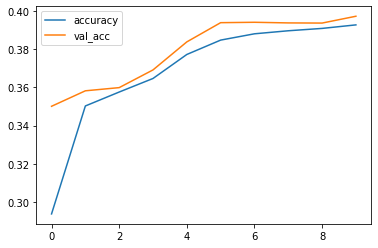

In [128]:
Results = model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test))
plt.plot(Results.history['acc'])
plt.plot(Results.history['val_acc'])

plt.legend(['accuracy', 'val_acc'], loc='upper left')

## 20 lags, 10 weights

lets check if adding more lags to our training data will increase accuracy

Epoch 1/10
6617/6617 [==============================] - 27s 4ms/step - loss: 2.1613 - acc: 0.2615 - val_loss: 1.9252 - val_acc: 0.3697
Epoch 2/10
6617/6617 [==============================] - 25s 4ms/step - loss: 1.9003 - acc: 0.3743 - val_loss: 1.8564 - val_acc: 0.3895
Epoch 3/10
6617/6617 [==============================] - 25s 4ms/step - loss: 1.8481 - acc: 0.3861 - val_loss: 1.8309 - val_acc: 0.3965
Epoch 4/10
6617/6617 [==============================] - 25s 4ms/step - loss: 1.8276 - acc: 0.3934 - val_loss: 1.8157 - val_acc: 0.3986
Epoch 5/10
6617/6617 [==============================] - 25s 4ms/step - loss: 1.8127 - acc: 0.3963 - val_loss: 1.8018 - val_acc: 0.4045
Epoch 6/10
6617/6617 [==============================] - 25s 4ms/step - loss: 1.7997 - acc: 0.4005 - val_loss: 1.7874 - val_acc: 0.4063
Epoch 7/10
6617/6617 [==============================] - 25s 4ms/step - loss: 1.7856 - acc: 0.4057 - val_loss: 1.7726 - val_acc: 0.4168
Epoch 8/10
6617/6617 [==============================] -

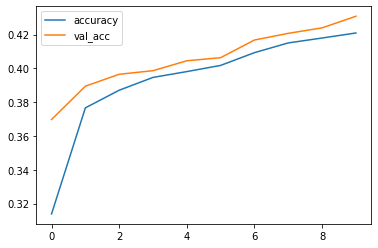

In [132]:
Results = model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test))
plt.plot(Results.history['acc'])
plt.plot(Results.history['val_acc'])

plt.legend(['accuracy', 'val_acc'], loc='upper left')

with the same amount of epochs the accuracy has improved and seems to have a positive slope, so lets try again with higher lags, and more epochs.

## 100 lags, 10 weights

because the lags are so small, lets increase it to 100 and see if the results differ in any way.

Epoch 1/25
5781/5781 [==============================] - 37s 6ms/step - loss: 2.1097 - acc: 0.2727 - val_loss: 1.8346 - val_acc: 0.4099
Epoch 2/25
5781/5781 [==============================] - 35s 6ms/step - loss: 1.7894 - acc: 0.4091 - val_loss: 1.6691 - val_acc: 0.4586
Epoch 3/25
5781/5781 [==============================] - 35s 6ms/step - loss: 1.6582 - acc: 0.4597 - val_loss: 1.6044 - val_acc: 0.4765
Epoch 4/25
5781/5781 [==============================] - 35s 6ms/step - loss: 1.6043 - acc: 0.4749 - val_loss: 1.5611 - val_acc: 0.5149
Epoch 5/25
5781/5781 [==============================] - 35s 6ms/step - loss: 1.5732 - acc: 0.4956 - val_loss: 1.5391 - val_acc: 0.5255
Epoch 6/25
5781/5781 [==============================] - 35s 6ms/step - loss: 1.5448 - acc: 0.5165 - val_loss: 1.5038 - val_acc: 0.5359
Epoch 7/25
5781/5781 [==============================] - 35s 6ms/step - loss: 1.5224 - acc: 0.5233 - val_loss: 1.4778 - val_acc: 0.5406
Epoch 8/25
5781/5781 [==============================] -

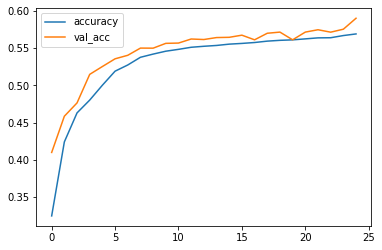

In [135]:
Results = model.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test))

plt.plot(Results.history['acc'])
plt.plot(Results.history['val_acc'])

plt.legend(['accuracy', 'val_acc'], loc='upper left')

the results are very clear, the number of lags increases the amount of data that can be learned and has a big effect on the results. Now we will start looking at multiple features, and we will need to balance the amount of features, with the amount of lags and the amount of subjects taken aswell to avoid memory crashes.

# **Multi-Features - 1 Subject**


In [19]:
testFeatures = ['HandMagno1','AnkleMagno1','HeartRate']
MultiFeatures,MultiLabels = create_train_data_Multi(AllSubjects[0],testFeatures,50,10,10)

['HandMagno1', 'AnkleMagno1', 'HeartRate', 'ActivityID']


In [10]:
MultiFeatures = testMulti.drop(testFeatures,axis=1)
MultiLabels = testMulti['ActivityID']
print(MultiFeatures)
print(MultiLabels)



        Feature0lag0  Feature0lag1  ...  Feature2lag48  Feature2lag49
2978         8.37572       8.59622  ...          100.0          100.0
2979         8.12991       8.37572  ...          100.0          100.0
2980         8.24079       8.12991  ...          100.0          100.0
2981         8.35481       8.24079  ...          100.0          100.0
2982         9.68086       8.35481  ...          100.0          100.0
...              ...           ...  ...            ...            ...
361795     -45.94930     -46.14460  ...          183.0          183.0
361796     -46.60210     -45.94930  ...          183.0          183.0
361797     -45.83020     -46.60210  ...          183.0          183.0
361798     -47.17750     -45.83020  ...          183.0          183.0
361799     -46.84460     -47.17750  ...          183.0          183.0

[203163 rows x 150 columns]
2978       0
2979       0
2980       0
2981       0
2982       0
          ..
361795    11
361796    11
361797    11
361798    11
3

In [11]:
a = MultiLabels.values
OneHotLabels = np.zeros((a.size, a.max()+1))
OneHotLabels[np.arange(a.size),a] = 1
OneHotLabels.shape

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(MultiFeatures, OneHotLabels, test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(182846, 150)
(182846, 12)
(20317, 150)
(20317, 12)


In [12]:
inp = Input(shape=(150,1))
x = LSTM(10)(inp)
x = Dense(12,activation="softmax")(x)
model = Model(inp,x)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics = ['acc'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 1)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 10)                480       
_________________________________________________________________
dense (Dense)                (None, 12)                132       
Total params: 612
Trainable params: 612
Non-trainable params: 0
_________________________________________________________________


## 3fx10lags

Epoch 1/10
6574/6574 [==============================] - 31s 5ms/step - loss: 1.9131 - acc: 0.2895 - val_loss: 1.2358 - val_acc: 0.5493
Epoch 2/10
6574/6574 [==============================] - 30s 5ms/step - loss: 1.1973 - acc: 0.5772 - val_loss: 1.0377 - val_acc: 0.6565
Epoch 3/10
6574/6574 [==============================] - 29s 4ms/step - loss: 0.9986 - acc: 0.6697 - val_loss: 0.9018 - val_acc: 0.7004
Epoch 4/10
6574/6574 [==============================] - 30s 5ms/step - loss: 0.9001 - acc: 0.6981 - val_loss: 0.8823 - val_acc: 0.7027
Epoch 5/10
6574/6574 [==============================] - 30s 5ms/step - loss: 0.8441 - acc: 0.7083 - val_loss: 0.8269 - val_acc: 0.7136
Epoch 6/10
6574/6574 [==============================] - 30s 5ms/step - loss: 0.8104 - acc: 0.7156 - val_loss: 0.7771 - val_acc: 0.7285
Epoch 7/10
6574/6574 [==============================] - 30s 4ms/step - loss: 0.7997 - acc: 0.7168 - val_loss: 0.9429 - val_acc: 0.6765
Epoch 8/10
6574/6574 [==============================] -

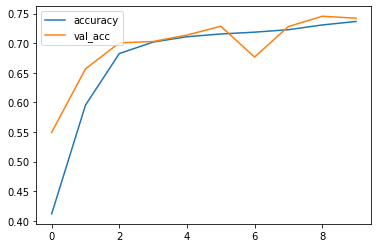

In [193]:
Results = model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test))
plt.plot(Results.history['acc'])
plt.plot(Results.history['val_acc'])

plt.legend(['accuracy', 'val_acc'], loc='upper left')

## 3fx50lags

Epoch 1/10
5714/5714 [==============================] - 51s 8ms/step - loss: 1.6874 - acc: 0.4143 - val_loss: 1.1618 - val_acc: 0.6153
Epoch 2/10
5714/5714 [==============================] - 42s 7ms/step - loss: 1.1142 - acc: 0.6088 - val_loss: 1.0383 - val_acc: 0.6269
Epoch 3/10
5714/5714 [==============================] - 42s 7ms/step - loss: 1.0300 - acc: 0.6271 - val_loss: 0.9701 - val_acc: 0.6517
Epoch 4/10
5714/5714 [==============================] - 43s 8ms/step - loss: 0.9839 - acc: 0.6433 - val_loss: 0.9458 - val_acc: 0.6541
Epoch 5/10
5714/5714 [==============================] - 42s 7ms/step - loss: 0.9366 - acc: 0.6579 - val_loss: 0.9040 - val_acc: 0.6760
Epoch 6/10
5714/5714 [==============================] - 42s 7ms/step - loss: 0.8880 - acc: 0.6795 - val_loss: 0.8410 - val_acc: 0.7007
Epoch 7/10
5714/5714 [==============================] - 43s 8ms/step - loss: 0.8494 - acc: 0.6970 - val_loss: 0.8345 - val_acc: 0.7066
Epoch 8/10
5714/5714 [==============================] -

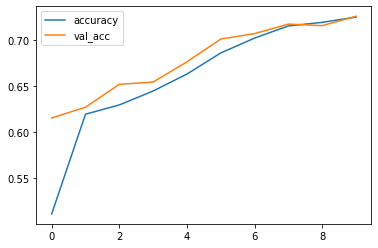

In [13]:
Results = model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test))
plt.plot(Results.history['acc'])
plt.plot(Results.history['val_acc'])

plt.legend(['accuracy', 'val_acc'], loc='upper left')

seems like working with multiple features the amount of lags had less of an impact, even so the results here are much better than before meaning the amount of features is also a parameter we need to analyze.

# **MultiFeatures Train 1-6, Test 7-8**

now for the first time we will test a model with the actualy test data (subjects 7-8). we will begin with a simple LSTM with 3 features.

In [73]:
TestFeatures,OneHotTestLabels = GetTestFeables(['HandMagno1','AnkleTemp','HeartRate'],10)
AllFeatures, OneHotLabels = GetAllFeables(['HandMagno1','AnkleTemp','HeartRate'],10)

print(AllFeatures.shape)
print(OneHotLabels.shape)
print(TestFeatures.shape)
print(OneHotTestLabels.shape)

(1349472, 30)
(1349472, 12)
(463641, 30)
(463641, 12)


In [ ]:
inp = Input(shape=(30,1))
x = LSTM(10)(inp)
x = Dense(12,activation="softmax")(x)
model = Model(inp,x)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics = ['acc'])
model.summary()

## 3f- 10 lags

Epoch 1/5
42171/42171 [==============================] - 184s 4ms/step - loss: 1.7086 - acc: 0.3787 - val_loss: 1.9394 - val_acc: 0.3267
Epoch 2/5
42171/42171 [==============================] - 182s 4ms/step - loss: 1.4008 - acc: 0.5085 - val_loss: 1.9685 - val_acc: 0.3345
Epoch 3/5
42171/42171 [==============================] - 183s 4ms/step - loss: 1.3190 - acc: 0.5404 - val_loss: 2.4505 - val_acc: 0.2621
Epoch 4/5
42171/42171 [==============================] - 179s 4ms/step - loss: 1.2202 - acc: 0.5739 - val_loss: 2.4403 - val_acc: 0.2758
Epoch 5/5
42171/42171 [==============================] - 180s 4ms/step - loss: 1.2034 - acc: 0.5774 - val_loss: 2.7235 - val_acc: 0.2493


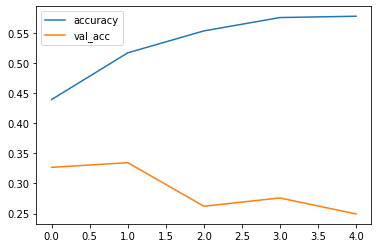

In [75]:
Results = model.fit(AllFeatures,OneHotLabels,epochs=5,validation_data=(TestFeatures,OneHotTestLabels))

plt.plot(Results.history['acc'])
plt.plot(Results.history['val_acc'])

plt.legend(['accuracy', 'val_acc'], loc='upper left')

seems like we have a case of overfitting, seeing as the loss is decreasing, but the validation_loss is increasing. lets try and add more lags first and see the results.

## **3f -50 lags**

In [47]:
TestFeatures,OneHotTestLabels = GetTestFeables(['HandMagno1','AnkleMagno1','HeartRate'],50)
AllFeatures, OneHotLabels = GetAllFeables(['HandMagno1','AnkleMagno1','HeartRate'],50)

print(AllFeatures.shape)
print(OneHotLabels.shape)
print(TestFeatures.shape)
print(OneHotTestLabels.shape)

['HandMagno1', 'AnkleMagno1', 'HeartRate', 'ActivityID']
['HandMagno1', 'AnkleMagno1', 'HeartRate', 'ActivityID']
['HandMagno1', 'AnkleMagno1', 'HeartRate', 'ActivityID']
['HandMagno1', 'AnkleMagno1', 'HeartRate', 'ActivityID']
['HandMagno1', 'AnkleMagno1', 'HeartRate', 'ActivityID']
['HandMagno1', 'AnkleMagno1', 'HeartRate', 'ActivityID']
['HandMagno1', 'AnkleMagno1', 'HeartRate', 'ActivityID']
['HandMagno1', 'AnkleMagno1', 'HeartRate', 'ActivityID']
(1167958, 150)
(1167958, 12)
(397436, 150)
(397436, 12)


In [48]:
inp = Input(shape=(150,1))
x = LSTM(10)(inp)
x = Dense(12,activation="softmax")(x)
model = Model(inp,x)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics = ['acc'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 1)]          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 12)                132       
Total params: 612
Trainable params: 612
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
36499/36499 [==============================] - 319s 9ms/step - loss: 1.5084 - acc: 0.4459 - val_loss: 1.4834 - val_acc: 0.4858
Epoch 2/5
36499/36499 [==============================] - 317s 9ms/step - loss: 1.2073 - acc: 0.5776 - val_loss: 1.5676 - val_acc: 0.4690
Epoch 3/5
36499/36499 [==============================] - 315s 9ms/step - loss: 1.1712 - acc: 0.5878 - val_loss: 1.4399 - val_acc: 0.4958
Epoch 4/5
36499/36499 [==============================] - 315s 9ms/step - loss: 1.1792 - acc: 0.5823 - val_loss: 1.4606 - val_acc: 0.4814
Epoch 5/5
36499/36499 [==============================] - 314s 9ms/step - loss: 1.1756 - acc: 0.5861 - val_loss: 1.4772 - val_acc: 0.5105


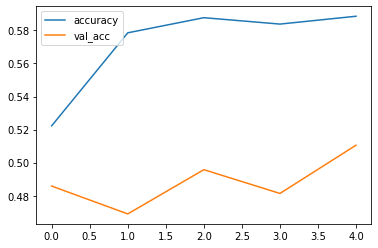

In [49]:
Results = model.fit(AllFeatures,OneHotLabels,epochs=5,validation_data=(TestFeatures,OneHotTestLabels))

plt.plot(Results.history['acc'])
plt.plot(Results.history['val_acc'])

plt.legend(['accuracy', 'val_acc'], loc='upper left')

much better! 

# **SelfSupervised**

As stated Before in the 1.c section we will try our selfsupervised learning on the HeartRate attribute. We will take the heartrate attribute of 90 consecutive rows, and try and predict the heartrate in the 100th row (prediction step of 10)

In [16]:
SSFeatures, SSTargets = createSelfSuper(AllSubjects[0],'HeartRate',100)
SSFeatures, SSTargets

SSTestFeatures, SSTestTargets = createSelfSuper(AllSubjects[7],'HeartRate',100)
SSTestFeatures, SSTestTargets

(        lag0  lag1  lag2  lag3  lag4  ...  lag85  lag86  lag87  lag88  lag89
 7936    79.0  79.0  79.0  79.0  79.0  ...   80.0   80.0   80.0   80.0   80.0
 7937    79.0  79.0  79.0  79.0  79.0  ...   80.0   80.0   80.0   80.0   80.0
 7938    79.0  79.0  79.0  79.0  79.0  ...   80.0   80.0   80.0   80.0   80.0
 7939    79.0  79.0  79.0  79.0  79.0  ...   80.0   80.0   80.0   80.0   80.0
 7940    79.0  79.0  79.0  79.0  79.0  ...   80.0   80.0   80.0   80.0   80.0
 ...      ...   ...   ...   ...   ...  ...    ...    ...    ...    ...    ...
 106406  78.0  78.0  78.0  78.0  78.0  ...   78.0   78.0   78.0   78.0   78.0
 106407  78.0  78.0  78.0  78.0  78.0  ...   78.0   78.0   78.0   78.0   78.0
 106408  78.0  78.0  78.0  78.0  78.0  ...   78.0   78.0   78.0   78.0   78.0
 106409  78.0  78.0  78.0  78.0  78.0  ...   78.0   78.0   78.0   78.0   78.0
 106410  78.0  78.0  78.0  78.0  78.0  ...   78.0   78.0   78.0   78.0   78.0
 
 [231676 rows x 90 columns], 7936      80.0
 7937      80.0
 7

In [19]:
from tensorflow.keras.layers import Dense, Conv2D, Dropout, MaxPool2D, Flatten, Input, BatchNormalization, LSTM

inp = Input(shape=(None,1))
x = LSTM(10)(inp)
x = Dense(1, activation='linear')(x)
SelfSupervisedM = Model(inp,x)
SelfSupervisedM.summary()
SelfSupervisedM.compile(loss='mse',optimizer='adam',metrics=['mae'])


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [20]:
SelfSupervisedM.fit(SSFeatures,SSTargets,epochs=5)

Epoch 1/5
7774/7774 [==============================] - 49s 5ms/step - loss: 12603.8978 - mae: 108.5960
Epoch 2/5
7774/7774 [==============================] - 41s 5ms/step - loss: 4962.1934 - mae: 64.5444
Epoch 3/5
7774/7774 [==============================] - 42s 5ms/step - loss: 1213.3769 - mae: 25.5345
Epoch 4/5
7774/7774 [==============================] - 41s 5ms/step - loss: 66.5848 - mae: 3.4018
Epoch 5/5
7774/7774 [==============================] - 41s 5ms/step - loss: 2.0854 - mae: 0.6405


In [9]:
SelfSupervisedM.fit(SSFeatures,SSTargets,epochs=5)

Epoch 1/5
7774/7774 [==============================] - 50s 6ms/step - loss: 11653.1352 - mae: 103.7176
Epoch 2/5
7774/7774 [==============================] - 43s 5ms/step - loss: 2623.5452 - mae: 42.9718
Epoch 3/5
7774/7774 [==============================] - 43s 6ms/step - loss: 188.0596 - mae: 6.4178
Epoch 4/5
7774/7774 [==============================] - 43s 6ms/step - loss: 3.4408 - mae: 0.8439
Epoch 5/5
7774/7774 [==============================] - 42s 5ms/step - loss: 0.3956 - mae: 0.3418


In [9]:
SSPredictions = SelfSupervisedM.predict(SSTestFeatures[:2000])
SSPredictions

array([[79.74761],
       [79.74761],
       [79.74761],
       ...,
       [77.92603],
       [77.92603],
       [77.92603]], dtype=float32)

In [21]:
SelfSupervisedM.save_weights('./checkpoints/my_checkpoint')
# SelfSupervisedM.load_weights('./checkpoints/my_checkpoint')

In [20]:
SSPredictions = SelfSupervisedM.predict(SSTestFeatures[:2000])
a = np.array(SSTestTargets[:2000]) # your x
b = np.concatenate(SSPredictions)

mses = ((a-b)**2).mean(axis=0)
mses

0.39233917554514647

the results is about 40%, thats good enough to start using as a base to our model. lets configure a new model to fit our original categorizing goal.


Tuning

In [22]:
TestFeatures,OneHotTestLabels = GetTestFeables(['HandMagno1','AnkleMagno1','HeartRate'],10)
AllFeatures, OneHotLabels = GetAllFeables(['HandMagno1','AnkleMagno1','HeartRate'],10)

print(AllFeatures.shape)
print(OneHotLabels.shape)
print(TestFeatures.shape)
print(OneHotTestLabels.shape)

(1349472, 30)
(1349472, 12)
(463641, 30)
(463641,)


In [25]:
TestLabels = np.zeros((OneHotTestLabels.size, OneHotTestLabels.max()+1))
TestLabels[np.arange(OneHotTestLabels.size),OneHotTestLabels] = 1
TestLabels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

removed the previous output layer and in its place we added a dense layer with - 12 outputs to fit the original prediction goal. We also changed the weights of the original self-supervised model to be untrainable to test their accuracy without further training, meaning they were only trained on the self-supervised task:

In [23]:
x = Dense(12, activation='softmax')(SelfSupervisedM.layers[-2].output)
SSTunedModel = Model(SelfSupervisedM.input,x)
SSTunedModel.compile(optimizer='adam',loss='categorical_crossentropy',
                metrics=['accuracy'])
SSTunedModel.summary()

SelfSupervisedM.trainable = False

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_2 (Dense)              (None, 12)                132       
Total params: 612
Trainable params: 612
Non-trainable params: 0
_________________________________________________________________


In [27]:
SSTunedModel.fit(AllFeatures,OneHotLabels,epochs=5, validation_data=(TestFeatures,TestLabels))

Epoch 1/5
42171/42171 [==============================] - 184s 4ms/step - loss: 1.1974 - accuracy: 0.5693 - val_loss: 1.8560 - val_accuracy: 0.4322
Epoch 2/5
42171/42171 [==============================] - 182s 4ms/step - loss: 1.1688 - accuracy: 0.5820 - val_loss: 1.8214 - val_accuracy: 0.4025
Epoch 3/5
42171/42171 [==============================] - 183s 4ms/step - loss: 1.1562 - accuracy: 0.5874 - val_loss: 2.2651 - val_accuracy: 0.3425
Epoch 4/5
42171/42171 [==============================] - 182s 4ms/step - loss: 1.1483 - accuracy: 0.5909 - val_loss: 1.7645 - val_accuracy: 0.4545
Epoch 5/5
42171/42171 [==============================] - 182s 4ms/step - loss: 1.1429 - accuracy: 0.5924 - val_loss: 1.9578 - val_accuracy: 0.4039


Considering the base of this model was made to predict Heartrate change 40% is a suprising result, it really shows the adaptive potential of transfer learning.

# **Improvements**



1.   More weights in the LSTM layer
2.   Adding complexity to the model, imcluding dropout and more learnable parameters.
3. add more features and lags.



# **Improved Model**

In [32]:
from tensorflow.keras.layers import Dense, Conv2D, Dropout, MaxPool2D, Flatten, Input, BatchNormalization, LSTM

inp = Input(shape=(60,1))
x = LSTM(15)(inp)
x = Dense(12, activation='softmax')(x)
ImprovedModel = Model(inp,x)
ImprovedModel.summary()
ImprovedModel.compile(loss='mse',optimizer='adam',metrics=['acc'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 15)                1020      
_________________________________________________________________
dense (Dense)                (None, 12)                192       
Total params: 1,212
Trainable params: 1,212
Non-trainable params: 0
_________________________________________________________________


In [32]:
# TestFeatures,OneHotTestLabels = GetTestFeables(['HeartRate', 'HandAcc1', 'HandMagno1', 'HandTemp', 'AnkleMagno1', 'AnkleTemp', 'ChestAcc1', 'ChestMagno1'],1)
# AllFeatures, OneHotLabels = GetAllFeables(['HeartRate', 'HandAcc1', 'HandMagno1', 'HandTemp', 'AnkleMagno1', 'AnkleTemp', 'ChestAcc1', 'ChestMagno1'],1)

TestFeatures,OneHotTestLabels = GetTestFeables(['HeartRate', 'HandMagno1','AnkleTemp'],20)
AllFeatures, OneHotLabels = GetAllFeables(['HeartRate', 'HandMagno1','AnkleTemp'],20)

print(AllFeatures.shape)
print(OneHotLabels.shape)
print(TestFeatures.shape)
print(OneHotTestLabels.shape)

(1292761, 60)
(1292761, 12)
(442962, 60)
(442962, 12)


In this model we tried to add more weights to the LSTM module (+5), and more lags (+10).

Epoch 1/10
10100/10100 [==============================] - 70s 6ms/step - loss: 0.0654 - acc: 0.3386 - val_loss: 37.3626 - val_acc: 0.2422
Epoch 2/10
10100/10100 [==============================] - 62s 6ms/step - loss: 0.0550 - acc: 0.4679 - val_loss: 37.3644 - val_acc: 0.1492
Epoch 3/10
10100/10100 [==============================] - 64s 6ms/step - loss: 0.0514 - acc: 0.5119 - val_loss: 37.3678 - val_acc: 0.1731
Epoch 4/10
10100/10100 [==============================] - 63s 6ms/step - loss: 0.0501 - acc: 0.5264 - val_loss: 37.3688 - val_acc: 0.1457
Epoch 5/10
10100/10100 [==============================] - 62s 6ms/step - loss: 0.0489 - acc: 0.5401 - val_loss: 37.3683 - val_acc: 0.1508
Epoch 6/10
10100/10100 [==============================] - 61s 6ms/step - loss: 0.0474 - acc: 0.5537 - val_loss: 37.3699 - val_acc: 0.1485
Epoch 7/10
10100/10100 [==============================] - 61s 6ms/step - loss: 0.0466 - acc: 0.5610 - val_loss: 37.3698 - val_acc: 0.1583
Epoch 8/10
10100/10100 [==========

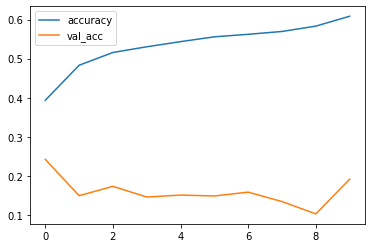

In [16]:
Results = ImprovedModel.fit(AllFeatures,OneHotLabels,epochs=10,validation_data=(TestFeatures,OneHotTestLabels),batch_size=128)

plt.plot(Results.history['acc'])
plt.plot(Results.history['val_acc'])

plt.legend(['accuracy', 'val_acc'], loc='upper left')

In this model we tried to add complexity to the base model - more layers ,more trainable parameters, and dropout.

In [29]:
from tensorflow.keras.layers import Dense, Conv2D, Dropout, MaxPool2D, Flatten, Input, BatchNormalization, LSTM

inp = Input(shape=(60,1))
x = LSTM(15)(inp)
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(12, activation='softmax')(x)
ImprovedModel = Model(inp,x)
ImprovedModel.summary()
ImprovedModel.compile(loss='mse',optimizer='adam',metrics=['acc'])

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 60, 1)]           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 15)                1020      
_________________________________________________________________
dense_8 (Dense)              (None, 128)               2048      
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 128)               1651

Epoch 1/5
40399/40399 [==============================] - 242s 6ms/step - loss: 0.0569 - acc: 0.4339 - val_loss: 0.1016 - val_acc: 0.1907
Epoch 2/5
40399/40399 [==============================] - 243s 6ms/step - loss: 0.0432 - acc: 0.5911 - val_loss: 0.0811 - val_acc: 0.3551
Epoch 3/5
40399/40399 [==============================] - 241s 6ms/step - loss: 0.0399 - acc: 0.6264 - val_loss: 0.1069 - val_acc: 0.1686
Epoch 4/5
40399/40399 [==============================] - 240s 6ms/step - loss: 0.0354 - acc: 0.6795 - val_loss: 0.0979 - val_acc: 0.2901
Epoch 5/5
40399/40399 [==============================] - 240s 6ms/step - loss: 0.0330 - acc: 0.7050 - val_loss: 0.0994 - val_acc: 0.2753


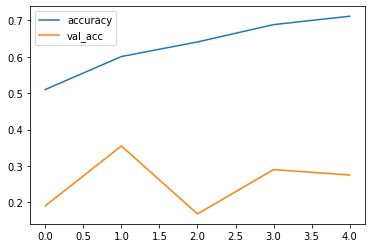

In [33]:
Results = ImprovedModel.fit(AllFeatures,OneHotLabels,epochs=5,validation_data=(TestFeatures,OneHotTestLabels))

plt.plot(Results.history['acc'])
plt.plot(Results.history['val_acc'])

plt.legend(['accuracy', 'val_acc'], loc='upper left')

Epoch 1/5
36499/36499 [==============================] - 426s 11ms/step - loss: 0.0487 - acc: 0.5395 - val_loss: 0.0889 - val_acc: 0.3006
Epoch 2/5
36499/36499 [==============================] - 412s 11ms/step - loss: 0.0296 - acc: 0.7447 - val_loss: 0.0987 - val_acc: 0.3008
Epoch 3/5
36499/36499 [==============================] - 414s 11ms/step - loss: 0.0249 - acc: 0.7867 - val_loss: 0.1083 - val_acc: 0.2500
Epoch 4/5
36499/36499 [==============================] - 417s 11ms/step - loss: 0.0239 - acc: 0.7947 - val_loss: 0.0895 - val_acc: 0.3315
Epoch 5/5
36499/36499 [==============================] - 410s 11ms/step - loss: 0.0318 - acc: 0.7236 - val_loss: 0.1019 - val_acc: 0.2965


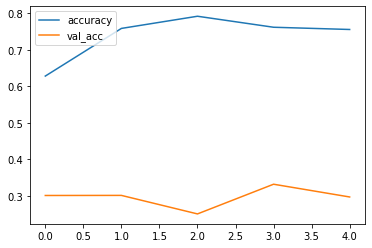

In [16]:
Results = ImprovedModel.fit(AllFeatures,OneHotLabels,epochs=5,validation_data=(TestFeatures,OneHotTestLabels))

plt.plot(Results.history['acc'])
plt.plot(Results.history['val_acc'])

plt.legend(['accuracy', 'val_acc'], loc='upper left')

The results aren't as good as our simple LSTM model, this can be caused by multiple reasons:


1. the low number of subjects that we are training on makes it hard to learn the data in a way that allows us to predict on a random person (in our case subjects 7-8), having many subjects would help generalize the weights more to fit the correct values and avoid overfitting.
2.   More lags would lead to more data being trained on at a time, because of memory capacity we werent able to test a large amount of features with a large amount of lags, which would probably lead to better results.

